<a href="https://colab.research.google.com/github/with-god/deep_learning/blob/main/20216138.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

지도 표시를 위해 Geopandas 설치

In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 3.3 MB/s 
     |████████████████████████████████| 15.4 MB 96 kB/s 
     |████████████████████████████████| 6.3 MB 39.0 MB/s 


구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

import IPython
import IPython.display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

데이터셋 호출

In [ ]:
df_path = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/deep_learning_2/20211216/total.csv', encoding='utf-8')
df_path = df_path[['ID', 'Date', 'Time', 'Status', 'Latitude', 'Longitude']]
df_path.head()

,ID,Date,Time,Status,Latitude,Longitude
0,AL011851,18510625,0,HU,28.0N,94.8W
1,AL011851,18510625,600,HU,28.0N,95.4W
2,AL011851,18510625,1200,HU,28.0N,96.0W
3,AL011851,18510625,1800,HU,28.1N,96.5W
4,AL011851,18510625,2100,HU,28.2N,96.8W


위경도 형식 변경

In [ ]:
df_path.Latitude = df_path.Latitude.apply(lambda x: float(x[:-1]) if x[-1] == 'N' else float(x[:-1]) * -1)
df_path.Longitude = df_path.Longitude.apply(lambda x: float(x[:-1]) if x[-1] == 'E' else float(x[:-1]) * -1)
df_path.head()

,ID,Date,Time,Status,Latitude,Longitude
0,AL011851,18510625,0,HU,28.0,-94.8
1,AL011851,18510625,600,HU,28.0,-95.4
2,AL011851,18510625,1200,HU,28.0,-96.0
3,AL011851,18510625,1800,HU,28.1,-96.5
4,AL011851,18510625,2100,HU,28.2,-96.8


날짜, 시간 형식 변경

In [ ]:
df_path['DateTime'] = df_path.Date.astype(str).str.cat(df_path.Time.astype(str).str.zfill(width=4)).astype(float)
df_path.head()

,ID,Date,Time,Status,Latitude,Longitude,DateTime
0,AL011851,18510625,0,HU,28.0,-94.8,1.851062e+11
1,AL011851,18510625,600,HU,28.0,-95.4,1.851063e+11
2,AL011851,18510625,1200,HU,28.0,-96.0,1.851063e+11
3,AL011851,18510625,1800,HU,28.1,-96.5,1.851063e+11
4,AL011851,18510625,2100,HU,28.2,-96.8,1.851063e+11


위경도를 Geopands에서 쓸 수 있게 컬럼추가

In [ ]:
gdf_path = gpd.GeoDataFrame(df_path, 
                            geometry=gpd.points_from_xy(df_path.Longitude, df_path.Latitude), 
                            crs='epsg:4326'
                           )
gdf_path.head()

,ID,Date,Time,Status,Latitude,Longitude,DateTime,geometry
0,AL011851,18510625,0,HU,28.0,-94.8,1.851062e+11,POINT (-94.80000 28.00000)
1,AL011851,18510625,600,HU,28.0,-95.4,1.851063e+11,POINT (-95.40000 28.00000)
2,AL011851,18510625,1200,HU,28.0,-96.0,1.851063e+11,POINT (-96.00000 28.00000)
3,AL011851,18510625,1800,HU,28.1,-96.5,1.851063e+11,POINT (-96.50000 28.10000)
4,AL011851,18510625,2100,HU,28.2,-96.8,1.851063e+11,POINT (-96.80000 28.20000)


위경도 값을 선으로 연결

In [ ]:
line_geometry = LineString(gdf_path['geometry'].head(30))
df_path_line = pd.DataFrame({'name' : 'total',
                             'geometry' : [line_geometry]}
                           )

gdf_path_line = gpd.GeoDataFrame(df_path_line, geometry=df_path_line.geometry)

아메리카 지도 위에 선으로 연결된 위경도 값을 표시

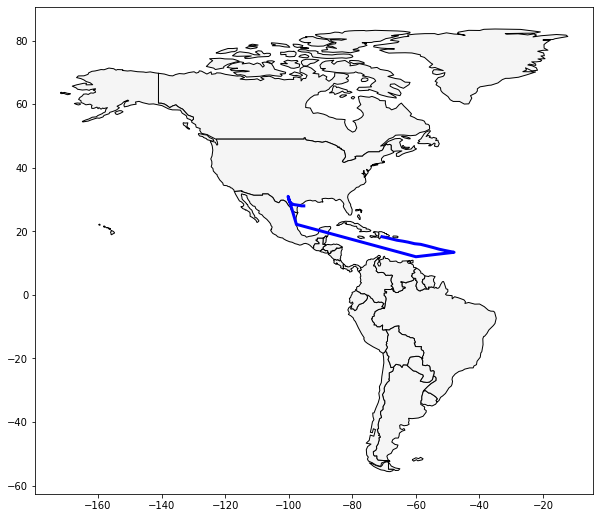

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
basemap = world.loc[world['continent'].isin(['North America', 'South America'])]
ax = basemap.plot(figsize=(10,10), color='whitesmoke', edgecolor='black', linewidth=1)
# ax.axis('off')
gdf_path_line.plot(ax=ax, linewidth=3., color='blue', zorder=1)

전체 위경도 값을 히트맵으로 표시

(-359.1, 179.9, 4.2, 81.0)

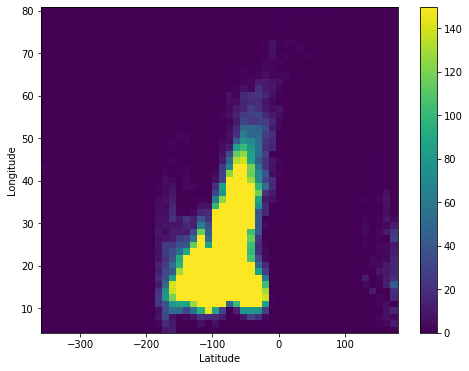

In [ ]:
plt.hist2d(df_path.Longitude, df_path.Latitude, bins=(50, 50), vmax=150)
plt.colorbar()
plt.xlabel('Latitude')
plt.ylabel('Longitude')
ax = plt.gca()
ax.axis('tight')

필요없는 데이터 삭제

In [ ]:
df_path.drop(['ID', 'Date', 'Time', 'geometry'], axis=1, inplace=True)
df_path.head()

,Status,Latitude,Longitude,DateTime
0,HU,28.0,-94.8,1.851062e+11
1,HU,28.0,-95.4,1.851063e+11
2,HU,28.0,-96.0,1.851063e+11
3,HU,28.1,-96.5,1.851063e+11
4,HU,28.2,-96.8,1.851063e+11


허리케인/태풍의 구분값 One-hot 인코딩

In [ ]:
# onehot = pd.get_dummies(data = df_path, columns = ['ID'], prefix = 'ID')
df = pd.get_dummies(data = df_path, columns = ['Status'], prefix = 'Status')
df.head()

,Latitude,Longitude,DateTime,Status_ DB,Status_ ET,Status_ EX,Status_ HU,Status_ HU,Status_ LO,Status_ PT,Status_ SD,Status_ SS,Status_ ST,Status_ TD,Status_ TS,Status_ WV
0,28.0,-94.8,1.851062e+11,0,0,0,1,0,0,0,0,0,0,0,0,0
1,28.0,-95.4,1.851063e+11,0,0,0,1,0,0,0,0,0,0,0,0,0
2,28.0,-96.0,1.851063e+11,0,0,0,1,0,0,0,0,0,0,0,0,0
3,28.1,-96.5,1.851063e+11,0,0,0,1,0,0,0,0,0,0,0,0,0
4,28.2,-96.8,1.851063e+11,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
def windowing(array, window_size):
    X = []
    Y = []

    for i in range(len(array)-window_size*2):
        X.append(array[i:i+window_size])
        Y.append(array[i+window_size:i + window_size*2])

    return np.asarray(X), np.asarray(Y)

데이터 노멀라이징, 윈도윙

In [ ]:
df = df - np.min(df, axis=0) + 0.0001
df = df / np.max(df, axis=0)

train_data = df[:int(len(df)*0.8)]
test_data = df[int(len(df) * 0.8):]

train_X, train_Y = windowing(train_data, 4)
test_X, test_Y = windowing(test_data, 4)

In [ ]:
print("Training X Size : " + str(train_X.shape))
print("Training Y Size : " + str(train_Y.shape))
print("Test X Size : " + str(test_X.shape))
print("Test Y Size : " + str(test_Y.shape))

Training X Size : (60185, 4, 16)
Training Y Size : (60185, 4, 16)
Test X Size : (15041, 4, 16)
Test Y Size : (15041, 4, 16)


LSTM 학습

In [ ]:
model = keras.Sequential([
    #keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)),
    keras.layers.LSTM(64, return_sequences=True), # unit: dimensionality of the output space
    keras.layers.Dense(32),
    keras.layers.Dense(16),
])

model.compile(optimizer="adam", metrics=["mae"], loss="mse") # mae: mean absolute error

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

EPOCHS = 100

history = model.fit(train_X, train_Y, epochs=EPOCHS,
                    validation_data=(test_X, test_Y), 
                    callbacks=[early_stop])

Epoch 1/100
1881/1881 [==============================] - 17s 7ms/step - loss: 0.0341 - mae: 0.0793 - val_loss: 0.0370 - val_mae: 0.0807
Epoch 2/100
1881/1881 [==============================] - 13s 7ms/step - loss: 0.0321 - mae: 0.0722 - val_loss: 0.0366 - val_mae: 0.0763
Epoch 3/100
1881/1881 [==============================] - 13s 7ms/step - loss: 0.0319 - mae: 0.0710 - val_loss: 0.0361 - val_mae: 0.0788
Epoch 4/100
1881/1881 [==============================] - 13s 7ms/step - loss: 0.0317 - mae: 0.0704 - val_loss: 0.0363 - val_mae: 0.0771
Epoch 5/100
1881/1881 [==============================] - 13s 7ms/step - loss: 0.0316 - mae: 0.0698 - val_loss: 0.0360 - val_mae: 0.0785
Epoch 6/100
1881/1881 [==============================] - 13s 7ms/step - loss: 0.0315 - mae: 0.0695 - val_loss: 0.0360 - val_mae: 0.0769
Epoch 7/100
1881/1881 [==============================] - 12s 6ms/step - loss: 0.0314 - mae: 0.0691 - val_loss: 0.0365 - val_mae: 0.0747
Epoch 8/100
1881/1881 [=========================

학습결과

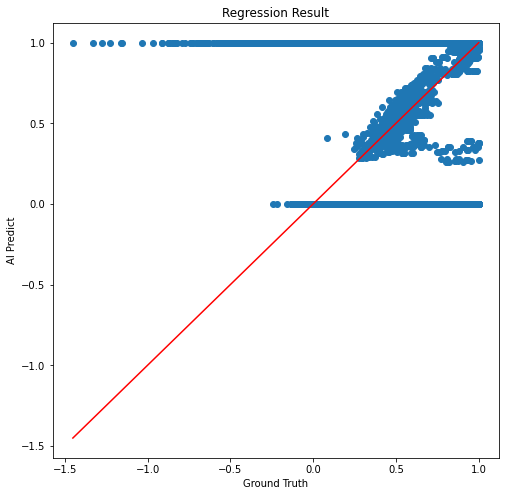

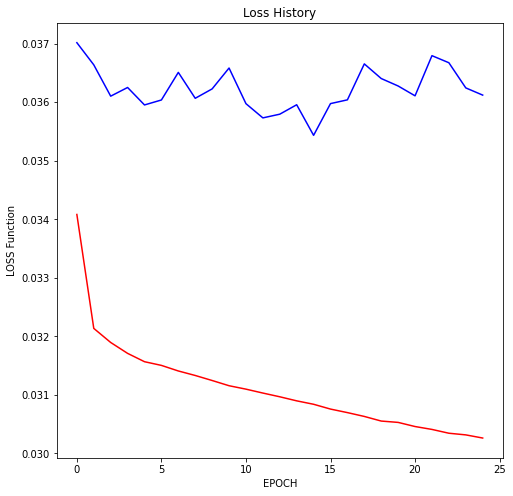

In [ ]:
prediction = model(test_X[:200])
label = test_Y[:200]

X = prediction / np.max(prediction, axis=0)
Y = label / np.max(label, axis=0)

minval = min(np.min(X), np.min(Y))
maxval = max(np.max(X), np.max(Y))

fig = plt.figure(figsize=(8, 8))
plt.title("Regression Result")
plt.xlabel("Ground Truth")
plt.ylabel("AI Predict")
plt.scatter(X, Y)
plt.plot([minval, maxval], [minval, maxval], "red")
fig.savefig("result.png")

train_history = history.history["loss"]
validation_history = history.history["val_loss"]
fig = plt.figure(figsize=(8, 8))
plt.title("Loss History")
plt.xlabel("EPOCH")
plt.ylabel("LOSS Function")
plt.plot(train_history, "red")
plt.plot(validation_history, 'blue')
fig.savefig("train_history.png")